# Sentiment Analysis - British Airway Reviews

In [4]:
# import libraries
import pandas as pd
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import requests
from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter


In [5]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [6]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"✅ Trip Verified | The seats were excellent, ..."
1,✅ Trip Verified | After the nightmare of get...
2,✅ Trip Verified | Prior to boarding a gate a...
3,✅ Trip Verified | I flew from Amsterdam to L...
4,"✅ Trip Verified | First the good news, the clu..."


In [7]:
# save to csv for futher analysis
df.to_csv("BA_reviews.csv")

In [8]:
# load csv
review_data = pd.read_csv('BA_reviews.csv')
print(review_data)

     Unnamed: 0                                            reviews
0             0  ✅ Trip Verified |   The seats were excellent, ...
1             1  ✅ Trip Verified |   After the nightmare of get...
2             2  ✅ Trip Verified |   Prior to boarding a gate a...
3             3  ✅ Trip Verified |   I flew from Amsterdam to L...
4             4  ✅ Trip Verified | First the good news, the clu...
..          ...                                                ...
995         995  ✅ Trip Verified |  Sydney to London via Singap...
996         996  Not Verified |  London to Johannesburg. Britis...
997         997  ✅ Trip Verified | I have to say travelling in ...
998         998  Not Verified |  I had a stress free journey wi...
999         999  ✅ Trip Verified |  Edinburgh to Kuala Lumpur v...

[1000 rows x 2 columns]


In [9]:
# drop index column
df_review = review_data.drop('Unnamed: 0', axis = 1)
df_review.head(10)

,reviews
0,"✅ Trip Verified | The seats were excellent, ..."
1,✅ Trip Verified | After the nightmare of get...
2,✅ Trip Verified | Prior to boarding a gate a...
3,✅ Trip Verified | I flew from Amsterdam to L...
4,"✅ Trip Verified | First the good news, the clu..."
5,✅ Trip Verified | I have never travelled wit...
6,"✅ Trip Verified | Terrible overall, medium ser..."
7,✅ Trip Verified | London Heathrow to Male In...
8,Not Verified | Very good flight following an ...
9,Not Verified | An hour's delay due to late ar...


In [10]:
# check missing value
missing_values = df_review.isnull().sum()
missing_values

reviews    0
dtype: int64

In [11]:
# remove unnessesary words
unused_words = ["✅ Trip Verified", "Not Verified"]
re_str = r"(✅\s*Trip\s*Verified|Not\s*Verified)".format("|".join(unused_words)) # find these words
df_review["reviews"] = df_review["reviews"].str.replace(re_str, "", regex=True) # replace them with ""
df_review["reviews"] = df_review["reviews"].str.strip('| ') # trim | character
df_review

,reviews
0,"The seats were excellent, with a feel of much ..."
1,After the nightmare of getting through triple ...
2,Prior to boarding a gate agent seemed to pick ...
3,I flew from Amsterdam to Las Vegas with a layo...
4,"First the good news, the club suites are such ..."
...,...
995,Sydney to London via Singapore with British Ai...
996,London to Johannesburg. British Airways is one...
997,I have to say travelling in Club Europe is a w...
998,I had a stress free journey with my 8 yr old a...


In [12]:
# preprocess text function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    return ' '.join(words)

# apply to the reviews
df_review["processed_reviews"] = df_review["reviews"].apply(preprocess_text)

# compute word frequent
all_words = ' '.join(df_review["processed_reviews"]).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# display the most common words
print("Most common words:")
for word, freq in common_words:
    print(f"{word}: {freq}")


Most common words:
flight: 1993
ba: 1280
service: 737
time: 538
london: 459
crew: 453
british: 448
seat: 445
food: 437
class: 431
airways: 428
good: 423
business: 403
seats: 383
staff: 382
hours: 367
cabin: 365
customer: 309
airline: 304
told: 299


### VADER wording analysis

In [13]:
# Initialise VADER analyser
vader_analyser = SentimentIntensityAnalyzer()

# function to classify comments
def classify_sentiment(text):
    score = vader_analyser.polarity_scores(text)
    return  "positive" if score["compound"] > 0 else "negative"

# classify comments
df_review["sentiment"] = df_review["processed_reviews"].apply(classify_sentiment)

# separate positive and negative comments
positive_reviews = ' '.join(df_review[df_review["sentiment"] == "positive"]["processed_reviews"]).split()
negative_reviews = ' '.join(df_review[df_review["sentiment"] == "negative"]["processed_reviews"]).split()

# compute word frequencies 
positive_word_freq = Counter(positive_reviews)
negative_word_freq = Counter(negative_reviews)

top_positive_words = positive_word_freq.most_common(20)
top_negative_words = negative_word_freq.most_common(20)

# display the most positive/negative words
print("Most positive words:")
for word, freq in top_positive_words:
    print(f"{word}: {freq}")

print("\nMost negative words:")
for word, freq in top_negative_words:
    print(f"{word}: {freq}")

Most positive words:
flight: 1001
ba: 677
service: 403
good: 371
crew: 333
time: 332
food: 298
seat: 260
cabin: 259
class: 255
business: 246
seats: 237
london: 224
british: 213
staff: 208
airways: 203
did: 166
boarding: 159
club: 158
just: 156

Most negative words:
flight: 992
ba: 603
service: 334
london: 235
british: 235
hours: 232
airways: 225
time: 206
customer: 195
told: 190
seat: 185
cancelled: 180
airline: 177
class: 176
staff: 174
business: 157
flights: 155
airport: 151
heathrow: 146
seats: 146


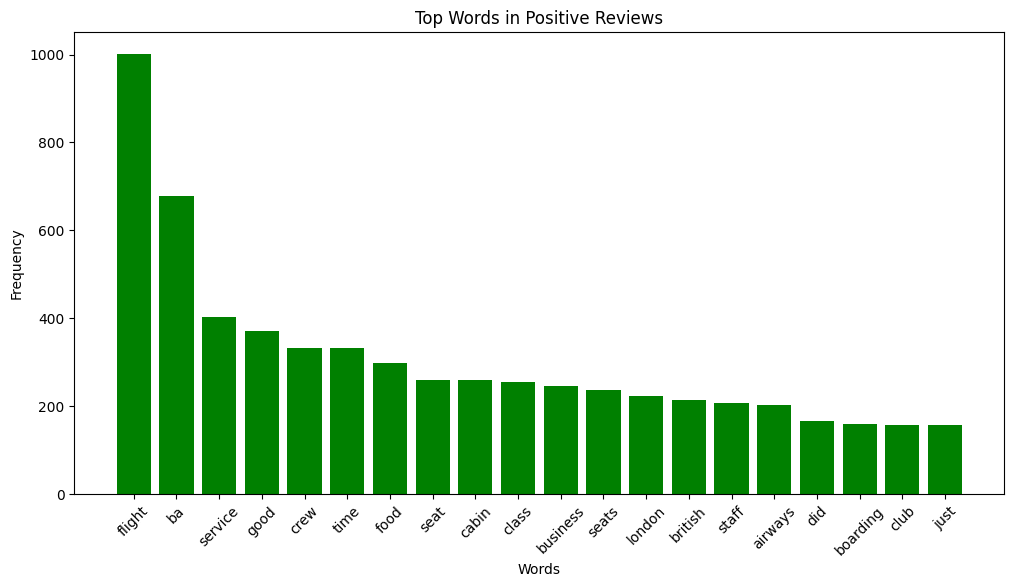

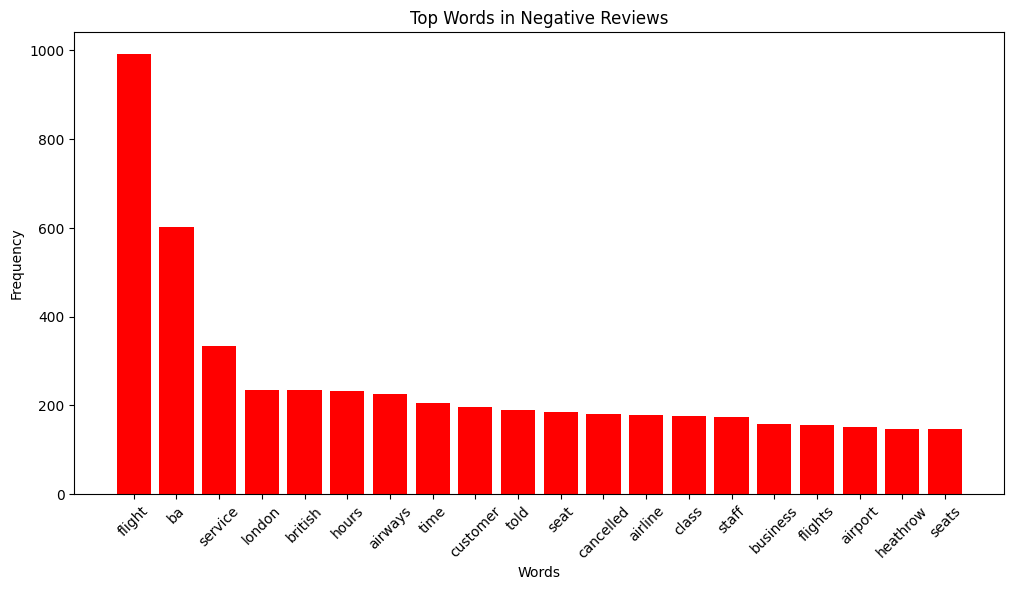

In [14]:
# display bar charts for positive and negative words
positive_words_df = pd.DataFrame(top_positive_words, columns=['word', 'frequency'])
negative_words_df = pd.DataFrame(top_negative_words, columns=['word', 'frequency'])

plt.figure(figsize=(12, 6))
plt.bar(positive_words_df['word'], positive_words_df['frequency'], color='green')
plt.title('Top Words in Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(negative_words_df['word'], negative_words_df['frequency'], color='red')
plt.title('Top Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### VADER review analysis

VADER Sentiment Distribution: 
vader_sentiment
positive    53.6
negative    44.5
neutral      1.9
Name: count, dtype: float64


C:\Users\acer\AppData\Local\Temp\ipykernel_33484\1481812672.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = vader_sentiment_distribution[i]


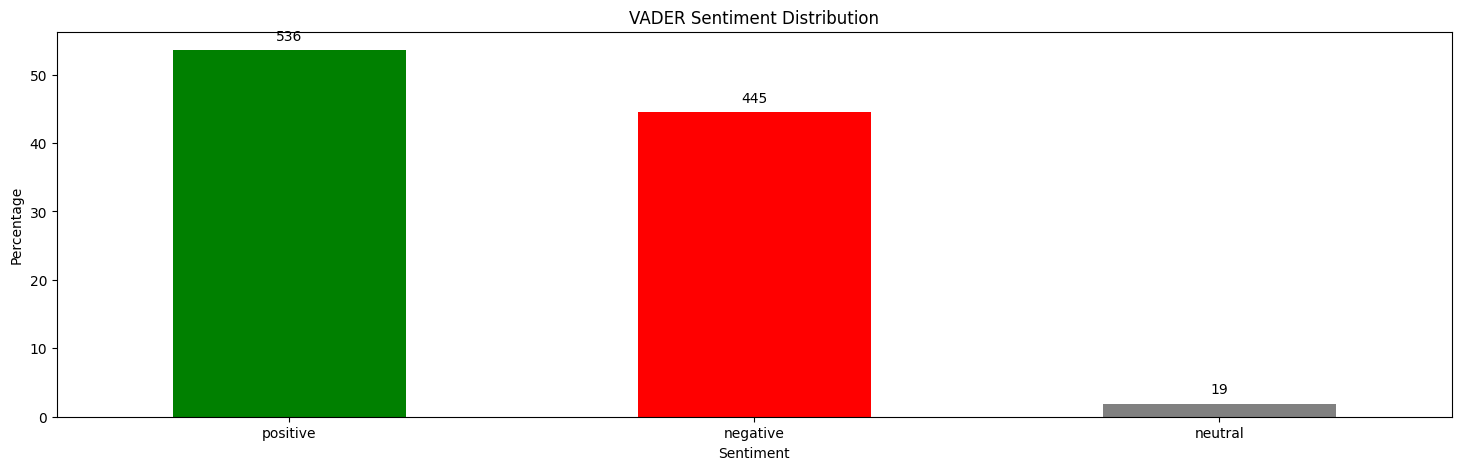

In [15]:
# Initialise VADER analyser
analyser = SentimentIntensityAnalyzer()

# function to classify comments
def classify_sentiment(text):
    score = analyser.polarity_scores(text)
    if score["compound"] > 0.05:
        return "positive"
    elif score["compound"] < -0.05:
        return "negative"
    else:
        return "neutral"

# apply VADER sentiment analysis
df_review["vader_sentiment"] = df_review["processed_reviews"].apply(classify_sentiment)

# calculate the distribution
vader_sentiment_counts = df_review["vader_sentiment"].value_counts()
vader_sentiment_distribution = vader_sentiment_counts / len(df_review) * 100
print("VADER Sentiment Distribution: ")
print(vader_sentiment_distribution)

# plotting the bar chart
plt.figure(figsize = (18, 5))
bar_plot = vader_sentiment_distribution.plot(kind = "bar", color = ["green", "red", "gray"])

# add annotations
for i, count in enumerate(vader_sentiment_counts):
    percentage = vader_sentiment_distribution[i]
    bar_plot.text(i, percentage + 1, f"{int(count)}", ha = "center", va = "bottom")

plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [16]:
# display first 10 reviews
print("Examples of reviews that VADER analysed:\n")
for index, row in df_review.head(10).iterrows():
    print(f"Review {index + 1}: {row['reviews']}")
    print(f"VADER Sentiment: {row['vader_sentiment']}")

Examples of reviews that VADER analysed:

Review 1: The seats were excellent, with a feel of much more room than the official seat pitch (I am 6ft 1in). We could sleep for a couple of hours (daytime flight), with the blinds down as they should be (no point booking a window seat in my view). I focus on seat quality much more than smiley faces and food (the food was middling, and the second meal, before landing, was distinctly sub-par).
VADER Sentiment: positive
Review 2: After the nightmare of getting through triple security at Nairobi Airport, I was looking forward to a glass of something lovely to unwind on the plane. Fat chance. An hour and a half after takeoff we were finally served a drink and meal together. I keep reading how well BA are now doing, but on both legs of this trip the crew were awful. The club suites are a great improvement but if the staff make no effort, what’s the point? On a positive note we were told my wife’s seat was broken and could not recline. I was going t